# 多层感知机

教程链接：https://zh-v2.d2l.ai/chapter_multilayer-perceptrons/mlp-scratch.html

In [1]:
%matplotlib inline
import random
import math
import numpy as np
import collections
import matplotlib.pyplot as plt
from IPython import display
import torchvision
from torchvision import transforms
import torch
from torch import nn

## 1. 导入 Fashion-MNIST 数据集

In [2]:
def get_dataloader_workers():
    """Use 4 processes to read the data.

    Defined in :numref:`sec_utils`"""
    return 4


def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory.

    Defined in :numref:`sec_utils`"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                                        num_workers=get_dataloader_workers()),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                                        num_workers=get_dataloader_workers()))

In [3]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)
type(train_iter)

torch.utils.data.dataloader.DataLoader

## 2. 初始化模型参数

In [4]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

## 3. 激活函数

In [5]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

## 4. 模型

In [6]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
    return (H@W2 + b2)

## 5. 损失函数

In [7]:
loss = nn.CrossEntropyLoss(reduction='none')

## 6. 必要构件

In [8]:
# 累加器
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [9]:
# 训练图作图器
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        self.use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: self.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
        
    @staticmethod
    def use_svg_display():
        """Use the svg format to display a plot in Jupyter.

        Defined in :numref:`sec_calculus`"""
        from matplotlib_inline import backend_inline
        backend_inline.set_matplotlib_formats('svg')
    
    @staticmethod
    def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """Set the axes for matplotlib.

        Defined in :numref:`sec_calculus`"""
        axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
        axes.set_xscale(xscale), axes.set_yscale(yscale)
        axes.set_xlim(xlim),     axes.set_ylim(ylim)
        if legend:
            axes.legend(legend)
        axes.grid()

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [10]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [11]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

## 7. 训练

In [12]:
# 单批量训练
def train_epoch(train_data, net, loss, updater):
    metric = Accumulator(4)  # 用于存储 (训练损失总和、训练准确度总和、样本数)
    for X, y in train_data:
        # print(X, y)
        # 正向传播
        y_hat = net(X)
        
        # 计算梯度
        l = loss(y_hat, y)

        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 反向传播
            l.sum().backward()

            # 使用优化器，更新参数
            # print("X.grad", X.grad)
            updater(X.shape[0])  # X.shape[0] 是批量大小 (batch_size)

        # 记录当前状态
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel(), 1)

    # 返回训练损失和训练精度
    # print(metric[:], )
    return metric[0] / metric[2],  metric[1] / metric[2], metric[3]

In [13]:
# 多批量训练
def train(num_epochs, net, train_data, test_data, loss, updater, ylim=[0.3, 1.0], need_assert=True):
    """
    num_epochs: 迭代周期个数
    net: 网络模型函数
    train_data: 训练集
    test_data: 测试集
    loss: 损失函数
    updater: 优化器
    """
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=ylim,
                        legend=['train loss', 'train acc', 'test acc'])
    
    batch_num = 0
    for epoch in range(num_epochs):
        train_metrics = train_epoch(train_data, net, loss, updater)
        test_acc = evaluate_accuracy(net, test_data)
        animator.add(epoch + 1, train_metrics[:2] + (test_acc,))  # train_metrics + (test_acc,) 是有三个元素的元组
        batch_num += train_metrics[2]
    train_loss, train_acc = train_metrics[:2]
    if need_assert:
        assert train_loss < 5, train_loss
        assert train_acc <= 1 and train_acc > 0.5, train_acc
        assert test_acc <= 1 and test_acc > 0.5, test_acc
    print("train_loss:", round(train_loss, 5))
    print("train_acc:", round(train_acc, 5))
    print("test_acc:", round(test_acc, 5))
    print("batch_num:", batch_num)

train_loss: 0.38417
train_acc: 0.86348
test_acc: 0.8314
batch_num: 2350.0


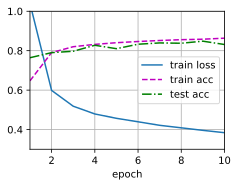

In [14]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
train(num_epochs, net, train_iter, test_iter, loss, updater)

## 8.  预测

In [15]:
def predict(net, test_data, n=6):
    """预测标签"""
    for X, y in test_data:
        break
    trues = y
    preds = net(X).argmax(axis=1)

    indexs = list(range(len(trues)))
    random.shuffle(indexs)
    for i in indexs[:n]:
        print("true:", y[i])
        print("pred:", preds[i])
        print("=" * 15)

In [16]:
predict(net, test_iter, n=6)

true: tensor(3)
pred: tensor(3)
true: tensor(1)
pred: tensor(1)
true: tensor(2)
pred: tensor(2)
true: tensor(4)
pred: tensor(4)
true: tensor(9)
pred: tensor(9)
true: tensor(2)
pred: tensor(2)


⚠️ 接着我们来解决 softmax 回归一节中引入的 XOR 问题

## 9. 生成 样本 和 样本标号

In [17]:
# 画图参数
COLORS = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
MARKERS = ['o', 'v', '^', 's', 'P']

# 业务参数
DIM = 3
CLUSTR_NUM = 10


def generate_sample(clustr_num, width=30, std=3, smin=600, smax=700, gen_seed=9603602):
    """生成样本
    clustr_num: 簇数
    width: 空间点位于长宽高均为 width 的正方体内
    std: 生成样本时，样本与样本中心距离的标准差
    smin: 生成样本量时，样本量的最小值
    smax: 生成样本量时，样本量的最大值
    """
    if clustr_num > len(COLORS) * len(MARKERS):
        raise Exception("Error: clustr_num <= len(COLORS) * len(MARKERS)")
    dim = DIM
    res = collections.defaultdict(list)
    
    random.seed(gen_seed)
    for i in range(clustr_num):
        mean = [random.random() * width for _ in range(dim)]
        sample_num = round((smax - smin) * random.random()) + smin
        for r in np.random.normal(0, std, sample_num):
            deg = [random.random() * math.pi * 2 for _ in range(2)]
            node = [mean[0] + r * math.cos(deg[0]) * math.cos(deg[1]),
                    mean[1] + r * math.cos(deg[0]) * math.sin(deg[1]),
                    mean[2] + r * math.sin(deg[0])]
        
            res[i].append(node)

    return res

In [18]:
def _3d_plot(samples):
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    mix = [(c, m) for c in COLORS for m in MARKERS]
    np.random.seed(19680801)
    np.random.shuffle(mix)
    for i, f in enumerate(samples.items()):
        k, v = f
        color, marker = mix[i]

        xs = [e[0] for e in v]
        ys = [e[1] for e in v]
        zs = [e[2] for e in v]
        ax.scatter(xs, ys, zs, color=color, marker=marker, label=k)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.legend = ax.legend(bbox_to_anchor=(.5, .30, .85, .5))

    plt.show()

In [19]:
def gen_xor_samples(clustr_num, partition):
    samples = dict(generate_sample(clustr_num))

    indexs = [i for i in range(clustr_num)]
    random.shuffle(indexs)

    xor_samples = collections.defaultdict(list)
    for i, label in enumerate(indexs):
        xor_samples[math.floor(i / partition)] += samples[label]
    return xor_samples

clustr_num = 16
partition = 2
xor_samples = gen_xor_samples(clustr_num, partition)
# xor_samples

In [20]:
_3d_plot(xor_samples)

## 2. 分割 训练集 和 测试集

将样本字典整成元组并打乱，分成训练集和测试集

In [21]:
def load_sample(samples, train_rate=0.8):
    lst = []
    for y, Xlist in samples.items():
        for X in Xlist:
            lst.append((X, y))

    random.shuffle(lst)
    train_num = math.floor(len(lst) * train_rate)

    train = lst[:train_num]
    test = lst[train_num:]

    return train, test

In [22]:
class MyDataLoader:
    def __init__(self):
        self._lst: list
        self.i = 0

    @property
    def lst(self):
        return self._lst
    
    @lst.setter
    def lst(self, value):
        self._lst = value
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.i < len(self._lst):
            i = self.i
            self.i += 1
            return self._lst[i]
        else:
            self.i = 0
            raise StopIteration


def data_iter(data, batch_size):
    """将 原始输入向量 拼接成 批量矩阵"""
    res = []
    batch_num = math.floor(len(data) / batch_size)
    for i in range(batch_num):
        start, end = batch_size * i, batch_size * (i + 1)
        # X = torch.tensor([e[0] for e in data[start:end]], requires_grad=True)
        X = torch.tensor([e[0] for e in data[start:end]])
        y = torch.tensor([e[1] for e in data[start:end]])
        res.append((X, y))
    
    dl = MyDataLoader()
    dl.lst = res
    
    return dl

In [23]:
xor_train_data, xor_test_data = load_sample(xor_samples)
# xor_train_data, xor_test_data

In [24]:
[e for e in xor_train_data][0]

([25.717320421170793, 27.630018701865858, 8.926882989433782], 6)

In [25]:
batch_size = 32
xor_train_iter = data_iter(xor_train_data, batch_size)
xor_test_iter = data_iter(xor_test_data, batch_size)
type(xor_train_iter), type(xor_test_iter)

(__main__.MyDataLoader, __main__.MyDataLoader)

In [26]:
# for e in xor_train_iter:
#     print(e)
#     break

In [27]:
# for X, y in xor_train_iter:
#     print(f"X.shape: {X.shape}")
#     print(f"X.type: {X.dtype}")
#     print(f"y.shape: {y.shape}")
#     print(f"y.type: {y.dtype}")
#     break

In [28]:
# X.reshape(-1, DIM)

In [29]:
num_inputs, num_outputs, num_hiddens = DIM, len(xor_samples.items()), 128
num_inputs, num_outputs, num_hiddens

(3, 8, 128)

In [30]:
# 初始化参数
W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True, dtype=torch.float64) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))

W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True, dtype=torch.float64) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

In [31]:
# 激活函数
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [32]:
# 网络模型
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)
    return (H@W2 + b2)

In [33]:
# 损失函数
loss = nn.CrossEntropyLoss(reduction='none')

train_loss: 0.59706
train_acc: 0.797
test_acc: 0.81152
batch_num: 2580.0


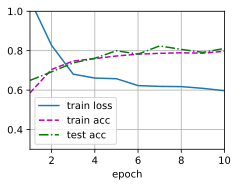

In [34]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
train(num_epochs, net, xor_train_iter, xor_test_iter, loss, updater)

背景知识小卡片1

In [35]:
# a = torch.Tensor([1,2,3,4,5,6])
# a.reshape(-1, 3)
# a

In [36]:
# a = torch.Tensor([1,2,3,4,5])
# a.reshape(-1, 3)
# a